# Free field with a cylinder - simulated using C code
To simulate a transverse free flow domain, periodic boundary conditions are applied on the top and bottom walls

C code is inspired by the LBJesseInletOutletBC notebook

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import sys
from numba import jit
from IPython import display
import warnings
import time
import subprocess

warnings.resetwarnings()

def print_fl(x):
    print(x)
    sys.stdout.flush()

In [2]:
# simulation parameters
delta_r = 1.0
c = 1
q = 7 # number of directions to be considered
num_iter = 10000
num_threads = 4

omega = 1.0/(0.51)     # Relaxation parameter.

# velocity vectors
e = np.zeros((q,2))
e_angles = np.linspace(0,2*np.pi,6,endpoint=False)
e[0,:] = [0,0]                        # zero velocity vector
e[1:,0] = np.cos(e_angles)
e[1:,1] = np.sin(e_angles)

# directional weights
w_e = np.concatenate(([1/2], 1/12*np.ones(6)))

# bounce-back directions
bb_dir = np.concatenate(([0], 1 + ((np.arange(q-1) + (q-1)/2) % 6)))
bb_dir = np.array(bb_dir, dtype=np.int)

/Users/jesse/anaconda/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/jesse/anaconda/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


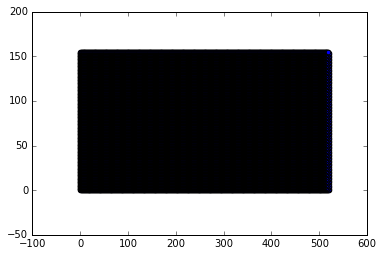

In [5]:
# generate grid (in this case triangular grid on rectangular domain)
N_x = 520
N_y = 180

L_x = N_x * delta_r
L_y = N_y * 1/2*np.sqrt(3)*delta_r

template_x = np.arange(N_x) * delta_r
template_y = np.arange(N_y) * 1/2*np.sqrt(3)*delta_r

x_points = np.size(template_x)
y_points = np.size(template_y)
n_points = x_points*y_points

assert N_x == x_points
assert N_y == y_points

template_xi = np.arange(x_points, dtype=np.int)
template_yi = np.arange(y_points, dtype=np.int)

[grid_x, grid_y] = np.meshgrid(template_x, template_y, indexing='ij')
[grid_xi, grid_yi] = np.meshgrid(template_xi, template_yi, indexing='ij')
grid_x[:,::2] += (1/2)*delta_r

neighbours_even_row = np.array([
        [0, 0],   # stationary direction
        [1, 0],   # +x direction
        [1, 1],   # up-right direction
        [0, 1],   # up-left direction
        [-1, 0],  # -x direction
        [0, -1],  # down-left direction
        [1, -1]   # down-right direction
    ])

neighbours_odd_row = np.array([
        [0, 0],   # stationary direction
        [1, 0],   # +x direction
        [0, 1],   # up-right direction
        [-1, 1],  # up-left direction
        [-1, 0],  # -x direction
        [-1, -1], # down-left direction
        [0, -1]   # down-right direction
    ])

left_dirs = np.array([3, 4, 5])
right_dirs = np.array([1, 2, 6])



link_matrix = np.ones((x_points, y_points, 7, 2), dtype=np.int) * -1

# construct the link matrix by finding neighbours (invalid ones are removed later)
link_matrix[:,::2,:,0] = (grid_xi[:,::2, np.newaxis] + neighbours_even_row[:,0]) % N_x
link_matrix[:,1::2,:,0] = (grid_xi[:,1::2, np.newaxis] + neighbours_odd_row[:,0]) % N_x

link_matrix[:,::2,:,1] = (grid_yi[:,::2, np.newaxis] + neighbours_even_row[:,1]) % N_y
link_matrix[:,1::2,:,1] = (grid_yi[:,1::2, np.newaxis] + neighbours_odd_row[:,1]) % N_y

link_matrix[0,::,left_dirs,:] = -1
link_matrix[-1,::,right_dirs,:] = -1

# reshape lattice into a list
lattice = np.zeros((n_points,2))

lattice[:,0] = grid_x.reshape(n_points)
lattice[:,1] = grid_y.reshape(n_points)

# clean up invalid links
link_matrix_inv_x = (link_matrix[:,:,:,0] >= x_points) | (link_matrix[:,:,:,0] < 0)
link_matrix_inv_y = (link_matrix[:,:,:,1] >= y_points) | (link_matrix[:,:,:,1] < 0)

link_matrix_inv = link_matrix_inv_x | link_matrix_inv_y

link_matrix[link_matrix_inv,:] = -1

# transform link matrix into a flat list that corresponds to the lattice list
link_list = np.array((link_matrix[:,:,:,0] * y_points + link_matrix[:,:,:,1]), dtype=np.int).reshape((n_points), 7)
link_list[link_list < 0] = -1

# plot grid
plt.scatter(lattice[:,0], lattice[:,1])
plt.show()

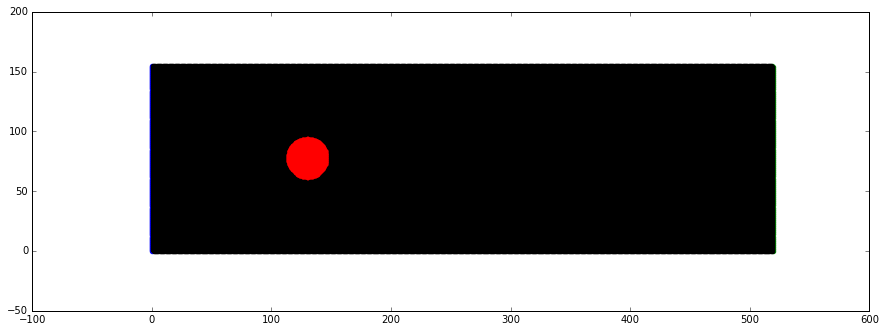

In [6]:
# identify different types of nodes
# bouncing walls identification
lower_wall_i = np.flatnonzero(lattice[:,1] == template_y[0])
upper_wall_i = np.flatnonzero(lattice[:,1] == template_y[-1])

# obstacle identification
obstacle_center = np.array([L_x/4, L_y/2])
obstacle_r = y_points/9

obstacle_i = np.flatnonzero(np.linalg.norm(lattice - obstacle_center, axis=1) < obstacle_r)
# obstacle_i = np.flatnonzero((np.abs(lattice - obstacle_center)[:,0] < obstacle_r) & (np.abs(lattice - obstacle_center)[:,1] < obstacle_r))

#bc_noslip_i = np.concatenate((lower_wall_i, upper_wall_i, obstacle_i))
bc_noslip_i = np.copy(obstacle_i)

# inlet/outlet points identification
bc_inlet_i = np.flatnonzero(lattice[:,0] < (template_x[0] + 3/4*delta_r))
bc_outlet_i = np.flatnonzero(lattice[:,0] > (template_x[-1] - 1/4*delta_r))

# remove conflicting points that have multiple boundary identities
bc_inlet_i = np.setdiff1d(bc_inlet_i, np.intersect1d(bc_inlet_i, bc_noslip_i))
bc_outlet_i = np.setdiff1d(bc_outlet_i, np.intersect1d(bc_outlet_i, bc_noslip_i))

boundary_i = np.concatenate((bc_noslip_i, bc_inlet_i, bc_outlet_i))
interior_i = np.setdiff1d(np.arange(n_points), boundary_i)

# plot the grid point identities with colors for inspection purposes
plt.figure(figsize=(15,15))
plt.scatter(lattice[bc_noslip_i, 0], lattice[bc_noslip_i, 1], color='r')
plt.scatter(lattice[bc_inlet_i, 0], lattice[bc_inlet_i, 1], color='b')
plt.scatter(lattice[bc_outlet_i, 0], lattice[bc_outlet_i, 1], color='g')
plt.scatter(lattice[interior_i, 0], lattice[interior_i, 1], color='k')
plt.gca().set_aspect('equal')
    

plt.show()

lattice_identities = np.zeros((n_points), dtype=np.int)
lattice_identities[interior_i] = 0
lattice_identities[bc_noslip_i] = 1
lattice_identities[bc_inlet_i] = 2
lattice_identities[bc_outlet_i] = 4

In [7]:
u_inlet = np.zeros((n_points, 2))
u_inlet[bc_inlet_i,:] = np.array([0.04, 0.0])[np.newaxis,:] * (1 + 1e-4 * np.sin(lattice[bc_inlet_i,1] * 2 * np.pi / L_y))[:,np.newaxis]
rho_inlet = np.ones((n_points)) * 1.0
rho_inlet[bc_noslip_i] = 0.0

In [8]:
# set initial conditions: velocity on the inflow boundary + equal density everywhere
initial_u = np.zeros((n_points, 2))
initial_u[:,:] = u_inlet[:,:]

initial_rho = np.zeros((n_points))
initial_rho[:] = rho_inlet[:]

In [9]:
q_arr = np.array([q], dtype=np.int)
num_iter_arr = np.array([num_iter], dtype=np.int)
omega_arr = np.array([omega])
num_threads_arr = np.array([num_threads], dtype=np.int)

In [10]:
np.savez("in.npz",
         lattice      = lattice,
         link_list    = link_list,
         lattice_identities   = lattice_identities,
         q            = q_arr,
         bb_dir       = bb_dir,
         u_inlet      = u_inlet,
         omega        = omega_arr,
         rho_inlet    = rho_inlet,
         e            = e,
         w_e          = w_e,
         initial_rho  = initial_rho,
         initial_u    = initial_u,
         num_iter     = num_iter_arr,
         num_threads  = num_threads_arr
        )

In [11]:
cmd = "./comp-phys-lb-worker"

p = subprocess.Popen(cmd,
                     stdout=subprocess.PIPE,
                     stderr=subprocess.STDOUT)

for line in iter(p.stdout.readline, b''):
    print(">>> " + line.decode("utf-8").rstrip())
    
p.stdout.close()

>>> Starting simulation with 93600 grid points and 10000 iterations with OpenMP
>>> Simulation progress: 0%
>>> Simulation progress: 10%
>>> Simulation progress: 20%
>>> Simulation progress: 30%
>>> Simulation progress: 40%
>>> Simulation progress: 50%
>>> Simulation progress: 60%
>>> Simulation progress: 70%
>>> Simulation progress: 80%
>>> Simulation progress: 90%
>>> Finished in 51.6748 s


In [12]:
data = np.load("out.npz")

u = data["u"]
rho = data["rho"]
lattice = data["lattice"]
link_list = data["link_list"]
l_id = data["lattice_identities"]

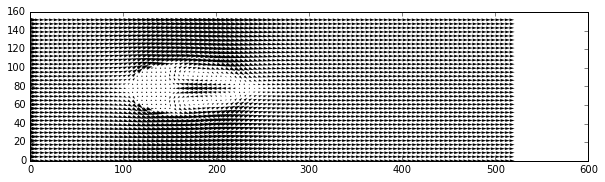

In [13]:
plt.figure(figsize=(10, 10))
# quiver grid
sp = 5
quiver_i = np.array(np.ravel(grid_xi[::sp, ::sp] * y_points + grid_yi[::sp, ::sp]), dtype=np.int)

plt.quiver(lattice[quiver_i,0], lattice[quiver_i,1], u[quiver_i,0], u[quiver_i,1])
plt.gca().set_aspect('equal')

plt.show()

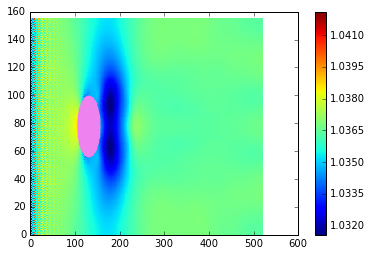

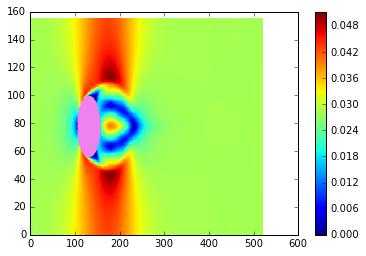

In [14]:
# plot results: density and magnitude of the velocity

lattice_grid = lattice.reshape(N_x,N_y,2)
u_grid = u.reshape(N_x,N_y,2)

rho_min = np.min(rho[rho > 0.5])
rho_max = np.max(rho)

plt.pcolor(lattice_grid[:,:,0], lattice_grid[:,:,1], rho.reshape(N_x, N_y), vmin=rho_min, vmax=rho_max)
plt.colorbar()
xlims = plt.xlim()
ylims = plt.ylim()
plt.scatter(lattice[obstacle_i,0],lattice[obstacle_i,1], color="violet")
plt.xlim(xlims)
plt.ylim(ylims)

plt.show()

plt.figure()
plt.pcolor(lattice_grid[:,:,0], lattice_grid[:,:,1], np.linalg.norm(u_grid, axis=2))
plt.colorbar()
xlims = plt.xlim()
ylims = plt.ylim()
plt.scatter(lattice[obstacle_i,0],lattice[obstacle_i,1], color="violet")
plt.xlim(xlims)
plt.ylim(ylims)
plt.show()